## Modelling

### Content:

1. Variable selection
2. Model 1: linear regression with 6 variables
3. Model 2: linear regression with 11 variables
4. Model 3: Ridge regression with 11 variables
5. Model 4: Lasso regression with 11 variables
6. Model 5: KNN


In [345]:
import requests
import json
import pandas as pd
import re
import math
import warnings
warnings.filterwarnings('ignore')
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from scipy.stats import norm, skew
from sklearn.linear_model import LogisticRegression
pd.set_option('display.max_columns', 50) # show all columns
pd.set_option('display.max_rows', 500) # show all rows
from matplotlib.colors import LogNorm
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn import neighbors
from math import sqrt
from sklearn.metrics import mean_squared_error 

In [298]:
df = pd.read_csv('../data/final_data2.csv')

In [299]:
df.isnull().sum()

LOCATION                          0
TIME                              0
Value_disposable_income           5
Value_adult_education             2
Value_alcohol_consumption         0
Value_air_pollution               0
Value_overweight_population      41
Value_avg_annual_hours            8
Happiness Rank                    0
HDI Rank (2017)                  86
income_inequality                 0
unemployment                      0
HDI_value                         3
Region                            0
Happiness Score                   0
Economy (GDP per Capita)          0
Family                            0
Health (Life Expectancy)          0
Freedom                           0
Trust (Government Corruption)     0
Generosity                        0
Dystopia Residual                 0
dtype: int64

## Variable selection

- We will not use 'HDI Rank (2017)' and 'Value_overweight_population' columns as predictors in the model since too much missing value and hard to fill-in. 
- Delete  happiness rank, as it shows same information as happincess score, as we have jusified before
- fill left few missing points using the mean of that column
- Draw scatter plot of target and each features to pick reasonable features

In [300]:
del df['HDI Rank (2017)']
del df['Value_overweight_population']
del df['Happiness Rank']

# fill the few missing point using the mean of that column
df['Value_adult_education'].fillna((df['Value_adult_education'].mean()), inplace=True)
df['Value_avg_annual_hours'].fillna((df['Value_avg_annual_hours'].mean()), inplace=True)
df['HDI_value'].fillna((df['HDI_value'].mean()), inplace=True)
df['Value_disposable_income'].fillna((df['Value_disposable_income'].mean()), inplace=True)

df.isnull().sum() # no missing value now!

LOCATION                         0
TIME                             0
Value_disposable_income          0
Value_adult_education            0
Value_alcohol_consumption        0
Value_air_pollution              0
Value_avg_annual_hours           0
income_inequality                0
unemployment                     0
HDI_value                        0
Region                           0
Happiness Score                  0
Economy (GDP per Capita)         0
Family                           0
Health (Life Expectancy)         0
Freedom                          0
Trust (Government Corruption)    0
Generosity                       0
Dystopia Residual                0
dtype: int64

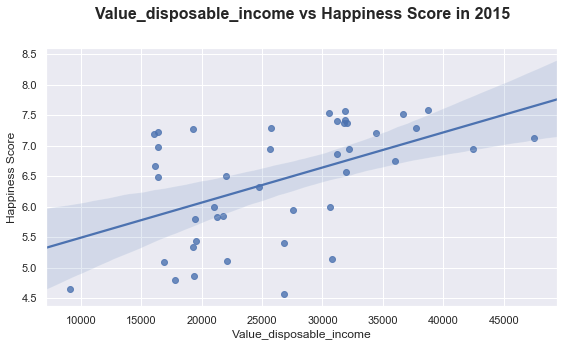

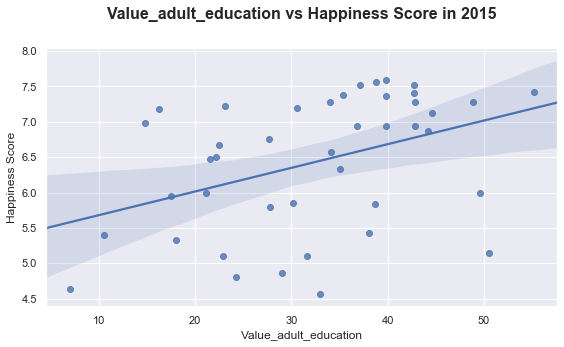

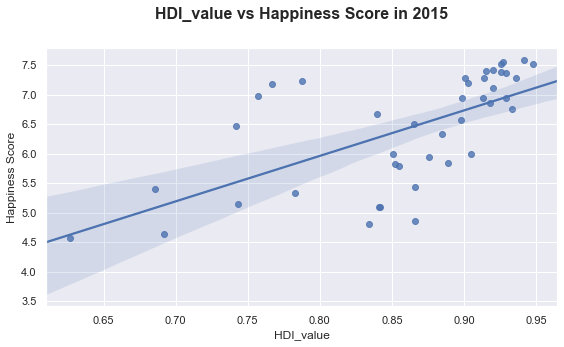

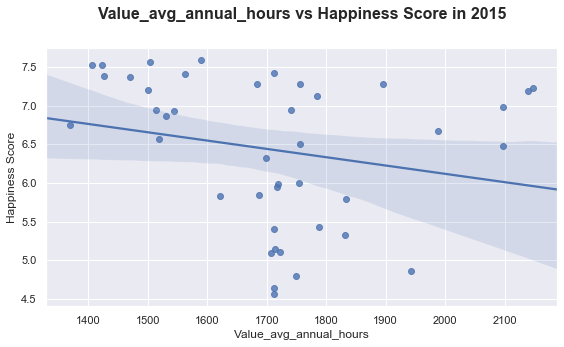

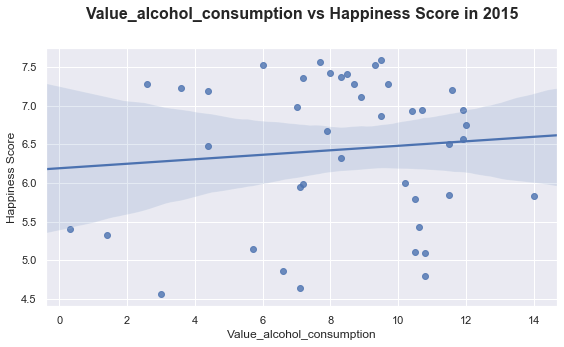

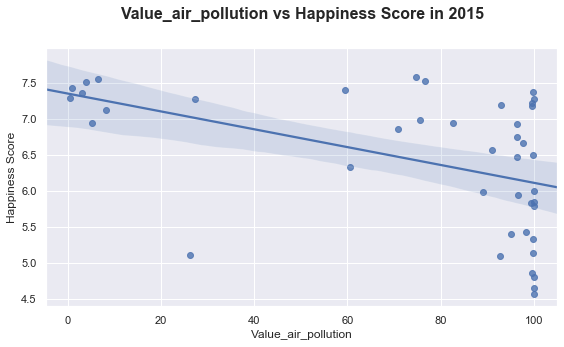

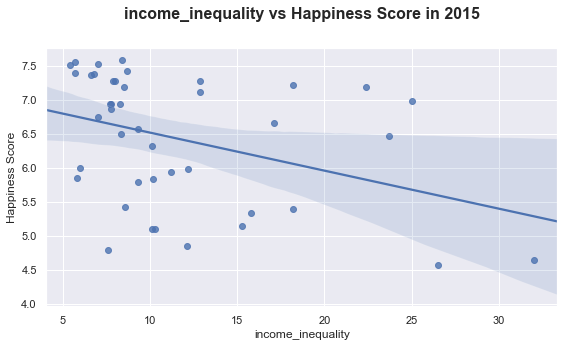

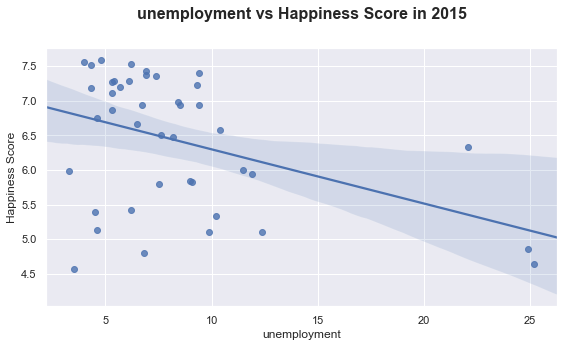

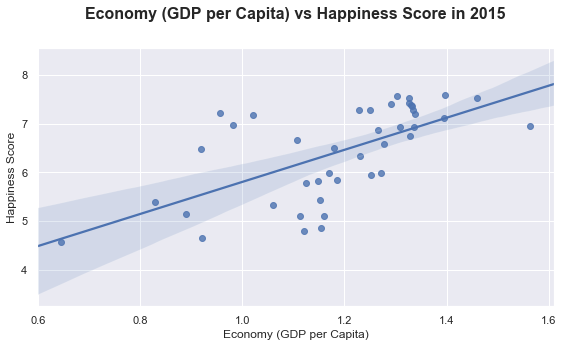

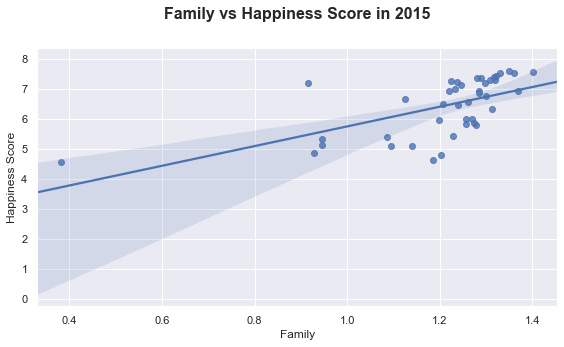

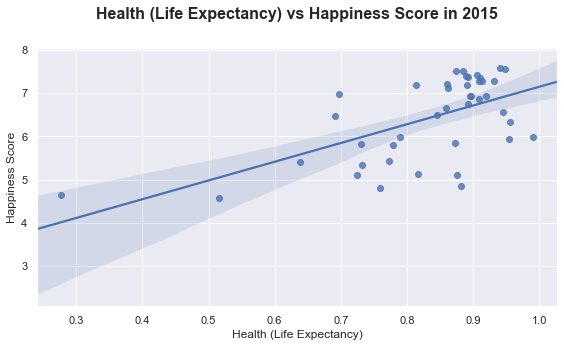

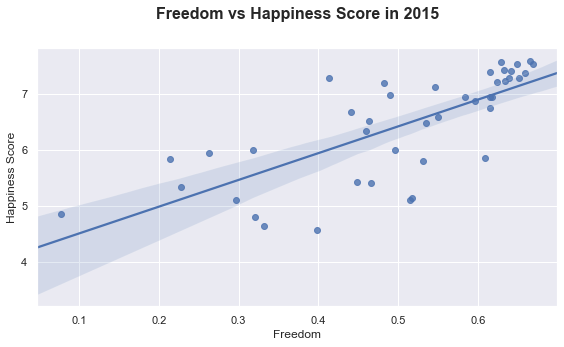

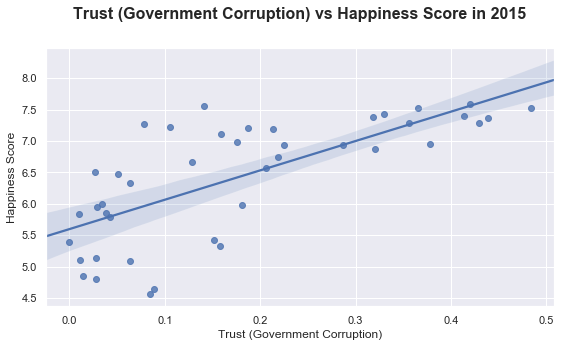

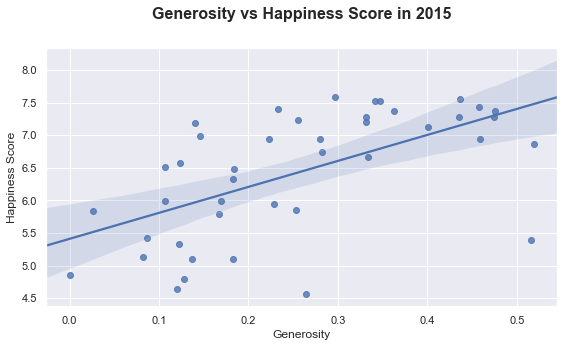

In [301]:
## Draw plots to check if linear relationship exists between
possible_features = [
        'Value_disposable_income','Value_adult_education',
         'HDI_value','Value_avg_annual_hours',
        'Value_alcohol_consumption', 'Value_air_pollution',
        'income_inequality',
       'unemployment', 
       'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)',
       'Freedom', 'Trust (Government Corruption)', 'Generosity']

for feature in possible_features:
    fig, ax = plt.subplots(figsize=(8,5))
    title = feature + " vs Happiness Score in 2015"
    ax = sns.regplot(x=feature, y="Happiness Score", data=df[df['TIME']==2015])
    #sns.scatterplot("Happiness Rank","Happiness Score", hue = 'TIME', data=df)
    ax.text(x=0.5, y=1.1, s=title, fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
    fig.tight_layout()
    plt.show()

From the sactter plot above, we can see that：
- Most variables have linear relationship with our target 'happiness score'. Thus, these variales are reasonable to be picked for OLS regressor. 

- `'Value_adult_education'`, `Value_alcohol_consumption`， `Value_avg_annual_hours` looks have no 'clear' linear relationship with happiness score. So I willnot use them in the linear regression.

### Split train and test dataset
- We use 2015 and 2016 data as trainset
- 2017 data for testing

In [302]:
train = df[df['TIME']!=2017]
test = df[df['TIME']==2017]

In [303]:
print(len(train)/(len(train)+len(test)))

0.6746031746031746


Thus, around 67% data in train set

In [304]:
# the features we will use in model1, our baseline
features_group1 = ['Economy (GDP per Capita)', 'Family','Health (Life Expectancy)','Freedom',
                   'Trust (Government Corruption)','Generosity']

## More features.
features_group2 = [
       'Value_disposable_income',
         'HDI_value',
         'Value_air_pollution',
        'income_inequality',
       'unemployment', 
       'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)',
       'Freedom', 'Trust (Government Corruption)', 'Generosity']

In [305]:
X_train = train[features_group1]
X_test = test[features_group1]

X_train_more = train[features_group2]
X_test_more = test[features_group2]  # 16 features


y_train = train['Happiness Score']
y_test = test['Happiness Score']

y_test = y_test.as_matrix() 

In [306]:
df['Happiness Score'].corr(df['Dystopia Residual'])

0.5968725731630378

## Normalization variables

In [307]:
def normalize(features_group, X_train, X_test):
    for feature in features_group:
         ### get mean and std from train dataset
        (mu_train, sigma_train) = norm.fit(X_train[feature])
        ### normalization this feature
        X_train[feature] = (X_train[feature] - mu_train) / sigma_train
        X_test[feature] = (X_test[feature] - mu_train) / sigma_train
    
    return X_train, X_test

In [308]:
X_train, X_test = normalize(features_group1, X_train, X_test)
X_train_more, X_test_more = normalize(features_group2, X_train_more, X_test_more)

In [309]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

## Model 1: linear regression with 6 variables 
features are 'Economy (GDP per Capita)', 'Family','Health (Life Expectancy)','Freedom',
                   'Trust (Government Corruption)','Generosity'

In [310]:
lr = LinearRegression()
lr.fit(X_train, y_train)


print('Intercept: \n', lr.intercept_)
print('Coefficients: \n', lr.coef_)
r_sq = lr.score(X_train, y_train)
print('coefficient of determination: \n', r_sq)

print("\n---------------Evaluation----------------------------------")
y_pred = lr.predict(X_test) # predict
regression_results(y_test, y_pred)

pred_actual_table = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
pred_actual_table

Intercept: 
 6.429870588235295
Coefficients: 
 [0.16386333 0.09048387 0.18947022 0.16933201 0.24582693 0.17241785]
coefficient of determination: 
 0.7167053233539813

---------------Evaluation----------------------------------
explained_variance:  0.6779
mean_squared_log_error:  0.0038
r2:  0.6605
MAE:  0.3579
MSE:  0.1969
RMSE:  0.4438


,Actual,Predicted
0,7.284,7.532280
1,7.006,7.098495
2,6.891,7.002121
3,7.316,7.438553
4,6.652,6.359915
5,6.609,6.200015
6,6.951,7.198108
7,7.522,7.538989
8,6.403,6.539279
9,5.611,6.368680


## Model 2: Linear regression with 11 variables
We include more information, and want to see if can get better result

In [311]:
lr2 = LinearRegression()
lr2.fit(X_train_more, y_train)


print('Intercept: \n', lr2.intercept_)
print('Coefficients: \n', lr2.coef_)
r_sq = lr2.score(X_train_more, y_train)
print('coefficient of determination: \n', r_sq)

print("\n---------------Evaluation----------------------------------")
y_pred = lr2.predict(X_test_more) # predict
regression_results(y_test, y_pred)

pred_actual_table = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
pred_actual_table

Intercept: 
 6.4298705882352944
Coefficients: 
 [-0.18391893  0.12567575  0.05094696  0.43446944 -0.19690967  0.40675701
  0.17033892  0.30548642  0.13264761  0.19571004  0.19833684]
coefficient of determination: 
 0.8030649730578949

---------------Evaluation----------------------------------
explained_variance:  0.7683
mean_squared_log_error:  0.0043
r2:  0.5929
MAE:  0.3946
MSE:  0.2361
RMSE:  0.4859


,Actual,Predicted
0,7.284,7.580082
1,7.006,7.225775
2,6.891,7.144656
3,7.316,7.503923
4,6.652,7.006780
5,6.609,6.303566
6,6.951,7.363263
7,7.522,7.627469
8,6.403,6.873889
9,5.611,6.462332


No, thus we consider add penalty factor to model

## Model 3: Ridge regression with  11 variables
Linear least squares with l2 regularization.
reason:
- Ridge Regression is a technique used when the data suffers from **multicollinearity** (independent variables are highly correlated). 
- when has more than features.

#### Estimate shrinkage parameter 
find best lambda

In [336]:
alphas = np.arange(0.001, 1, 0.001).tolist()

In [338]:
len(alphas)

999

In [337]:
clf = RidgeCV(alphas=alphas) # use Cross-validation to select best lambda
clf.fit(X_train_more, y_train) 

y_pred = clf.predict(X_test_more) # predict
regression_results(y_test, y_pred)

pred_actual_table = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
pred_actual_table

explained_variance:  0.7701
mean_squared_log_error:  0.0041
r2:  0.6173
MAE:  0.3796
MSE:  0.222
RMSE:  0.4711


,Actual,Predicted
0,7.284,7.569178
1,7.006,7.203938
2,6.891,7.127004
3,7.316,7.488954
4,6.652,6.952756
5,6.609,6.291040
6,6.951,7.351379
7,7.522,7.614361
8,6.403,6.832008
9,5.611,6.459495


## Model 4: lasso regression with  11 variables
Linear least squares with l1 regularization.

In [330]:
clf = LassoCV(cv=10, random_state=0) # use Cross-validation to select best lambda
clf.fit(X_train_more, y_train) 

y_pred = clf.predict(X_test_more) # predict
regression_results(y_test, y_pred)

pred_actual_table = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
pred_actual_table

explained_variance:  0.7665
mean_squared_log_error:  0.0043
r2:  0.602
MAE:  0.3862
MSE:  0.2309
RMSE:  0.4805


,Actual,Predicted
0,7.284,7.578369
1,7.006,7.213138
2,6.891,7.128855
3,7.316,7.508931
4,6.652,6.949644
5,6.609,6.303937
6,6.951,7.343043
7,7.522,7.616270
8,6.403,6.853292
9,5.611,6.462769


## Model 5: KNN with 11 variables
Since no clear linear pattern, so we try KNN to see if can get better result

In [346]:
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    model.fit(X_train_more, y_train)  #fit the model
    y_pred=model.predict(X_test_more)#make prediction on test set
    error = sqrt(mean_squared_error(y_test,y_pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.2699052794531759
RMSE value for k=  2 is: 0.27558431228581876
RMSE value for k=  3 is: 0.32966779040086214
RMSE value for k=  4 is: 0.3668157638010359
RMSE value for k=  5 is: 0.37489322494669164
RMSE value for k=  6 is: 0.4131302584974253
RMSE value for k=  7 is: 0.44899713481036063
RMSE value for k=  8 is: 0.4580745968285377
RMSE value for k=  9 is: 0.46783432468261327
RMSE value for k=  10 is: 0.484144766139673
RMSE value for k=  11 is: 0.4638103058991848
RMSE value for k=  12 is: 0.4590063823193338
RMSE value for k=  13 is: 0.45557959831571365
RMSE value for k=  14 is: 0.45498118741375254
RMSE value for k=  15 is: 0.45122771828523206
RMSE value for k=  16 is: 0.4438229597799141
RMSE value for k=  17 is: 0.43502281783206914
RMSE value for k=  18 is: 0.4524891542916506
RMSE value for k=  19 is: 0.44462333197133297
RMSE value for k=  20 is: 0.45499405820019123


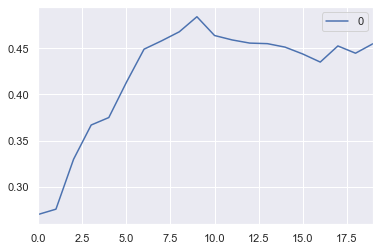

In [347]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

In [349]:
Thus , best K is k = 1. But k = 1 is apparently overfitting. 

SyntaxError: invalid syntax (<ipython-input-349-ced17cfebbd5>, line 1)

In [348]:
lr3 = neighbors.KNeighborsRegressor(n_neighbors = 1)  # select k = 1
lr3.fit(X_train_more, y_train)


print('Intercept: \n', lr2.intercept_)
print('Coefficients: \n', lr2.coef_)
r_sq = lr2.score(X_train_more, y_train)
print('coefficient of determination: \n', r_sq)

print("\n---------------Evaluation----------------------------------")
y_pred = lr2.predict(X_test_more) # predict
regression_results(y_test, y_pred)

pred_actual_table = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
pred_actual_table

Intercept: 
 6.4298705882352944
Coefficients: 
 [-0.18391893  0.12567575  0.05094696  0.43446944 -0.19690967  0.40675701
  0.17033892  0.30548642  0.13264761  0.19571004  0.19833684]
coefficient of determination: 
 0.8030649730578949

---------------Evaluation----------------------------------
explained_variance:  0.7683
mean_squared_log_error:  0.0043
r2:  0.5929
MAE:  0.3946
MSE:  0.2361
RMSE:  0.4859


,Actual,Predicted
0,7.284,7.580082
1,7.006,7.225775
2,6.891,7.144656
3,7.316,7.503923
4,6.652,7.006780
5,6.609,6.303566
6,6.951,7.363263
7,7.522,7.627469
8,6.403,6.873889
9,5.611,6.462332
